Tài liệu:

 [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/multi-armed-bandit-problem-in-reinforcement-learning/)

[github](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html)

### Bài toán 
Động lực: không thể chọn explore và exploit cùng lúc 

Giải pháp: lựa chọn Hành động theo giới hạn trên khoảng tin cậy (Upper Confidence Bound - UCB)
$$ Confident\_Interval = \argmax_a \Big(Q_t(a) + c \sqrt{\frac{\ln(t)}{N_t(a)}} \Big) $$
Khoảng tin cậy cho ta biết độ tin cậy giá trị hành động thực tế của hành động A nằm ở đâu trong vùng này
- Nếu vùng này nhỏ: chắc chắc giá trị của A gần với ước tính 
- Ngược lại, không hcawcs chắn giá trị hành động A gần với ước tính 

Nguyên tắc: lạc quan với sự không chắc chắn, tức là nếu không biết chọn hành động nào thì chọn hành động có Upper Bound lớn nhất. 

### Cơ sở toán học: 

- Bất đẳng thức Hoeffding: nôm na là cho thấy xác suất để giá trị thực $\mu$ vượt quá giá trị trung bình quan sát $\bar{X}$ một khoảng $\Delta$ sẽ giảm rất nhanh theo hàm mũ khi mẫu $n$ tăng lên: 
$$S_n = \sum_{i=1}^{n} X_i$$
Công thức gốc 
$$ P(S_n - E[S_n] \geq t) \leq \exp \left( -\frac{2t^2}{\sum (b_i - a_i)^2} \right) (1) $$
Một trường hợp với: 
$$ P(\mu - \bar{X} > \Delta) \le \exp(-2n\Delta^2) (2)$$
<br> $\bar{X} \to \frac{S_n}{n}$ : trung bình mẫu của $n$ bnn độc lập
<br> $\mu \to E[\bar{X}]/n$ : giá trị kỳ vọng thực 
<br> $\Delta \to t/n$ : Độ lệch 
<br> $X_i \in [0,1]$ nên $(b_i-a_i)^2 = 1$ nên $\sum_{i=1}^{n} (b_i-a_i)^2 = n$

Thay hết mấy cái trên vào (1), đồng thời xoay chiều để tìm "trần", ta suy ra 2

Tìm upper bound: 
$$ P(\mu > \bar{X} + \Delta) \le \exp(-2n\Delta^2) = p$$
Lấy loganepe 2 vế: 
$$ -2n \Delta^2 = ln(p) \implies \Delta = \sqrt{\frac{\ln(1/p)}{2n}} $$
Làm sao để xác suất rủi ro giảm dần theo $t$ ? Chọn $p = \frac{1}{t^{\alpha}}$. Vậy 
$$\Delta = \sqrt{\frac{\alpha \ln(t)}{2n}} = c \sqrt{\frac{\ln(t)}{N_t(a)}}$$

- Khoảng tin cậy: $Upper\_Bound = \bar{X_a} + U_a$

Giá trị được chọn phổ biến là: 
$$A_t = \arg \max_{a} \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$$

- Sự hội tụ và luật số lớn: Ý tưởng là khi kéo một tay máy càng nhiều lần, độ tin cậy sẽ nhỏ lại 
- Lý thuyết Regret (Hối tiếc): Mức độ "sai lầm" của thuật toán tuân theo hàm log, tăng chậm theo thời gian, giúp tối ưu về mặt toán học (ít nhất là hơn epsilon-greedy)

### Triển khai 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
class UCB:
    def __init__(self, n_arms, c):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0
        self.c = c
    
    def select_arm(self):
        ucb_values = self.values + self.c * np.sqrt( np.log(self.total_counts+1) / (self.counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value_past = self.values[chosen_arm]
        self.values[chosen_arm] = (n-1) / n * value_past + 1/n * reward

In [3]:
''' 
Thiết lập trạng thái ban đầu 
true_means : kỳ vọng reward của một máy 
''' 
np.random.seed(6)
true_means = np.random.randn(10)
print(f"Sum of mean is: {sum(true_means)}")
print(f"Actual mean rewards for each arm: \n {np.round(true_means, 2)}")
print(f"The best arm is #{np.argmax(true_means)} with a mean of {np.max(true_means):.2f} \n")

Sum of mean is: -1.015211911465167
Actual mean rewards for each arm: 
 [-0.31  0.73  0.22 -0.9  -2.49  0.91  1.13 -1.51  1.64 -0.43]
The best arm is #8 with a mean of 1.64 



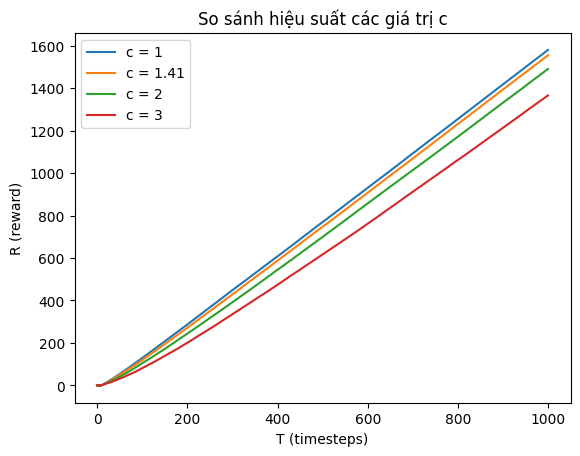

In [7]:
''' Mẫu chạy thử '''
n_arms = 10
C_array = [1, 1.41, 2, 3]
T = 1000
n_runs = 200 # Chạy nhiều lần để lấy trung bình 

''' Lưu kết quả '''
results = {}

for c in C_array:
    all_runs_reward = [] #chạy 200 lần và lấy trung bình 

    for run in range(n_runs):
        agent = UCB(n_arms, c)
        
        rewards = []
        for t in range(T):
            arm_to_pull = agent.select_arm()
            reward = np.random.randn() + true_means[arm_to_pull]
            agent.update(arm_to_pull, reward)
            rewards.append(reward)

        all_runs_reward.append(rewards)

    results[c] = np.mean(all_runs_reward, axis = 0)

for eps, avg_reward in results.items():
    plt.plot(np.cumsum(avg_reward), label=f'c = {eps}')


plt.xlabel("T (timesteps)")
plt.ylabel("R (reward)")
plt.legend()
plt.title("So sánh hiệu suất các giá trị c")
plt.show()